# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Checking to see if GPU is available
#Just purchased a new Macbook Pro with M1 Max chip. 
#Still not able to figure out how to use the 32 cores of GPU built in
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
train_transforms = transforms.Compose([transforms.Resize(32),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

# Specify batch size
batch_size = 32

# Create training set and define training dataloader
train_set = torchvision.datasets.CIFAR10('CIFAR10_data/', download=True, train=True, 
                                          transform=train_transforms)
# Create test set and define test dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Create validation set and define validation dataloader
test_data = torchvision.datasets.CIFAR10('CIFAR10_data/', download=True, train=False, 
                                          transform=test_transforms)

#Using 90% of test data for testing and 10% for validation
test_size = int(len(test_data)*0.8)
val_size = int(len(test_data) - test_size)
test_set, val_set = torch.utils.data.random_split(test_data, [test_size, val_size])

# Defining test and validation dataloaders
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10_data/cifar-10-python.tar.gz to CIFAR10_data/
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
# Using the len function to see the number of images in the training, validation, and test sets.
print('Number of images in the training set:', len(train_set))
print('Number of images in the validation set:', len(val_set))
print('Number of images in the test set:', len(test_set))
print('Total number of images in the CIFAR-10 dataset:', len(train_set)+len(val_set)+len(test_set))

Number of images in the training set: 50000
Number of images in the validation set: 2000
Number of images in the test set: 8000
Total number of images in the CIFAR-10 dataset: 60000


In [5]:
# Checking the size and shape of random images in the dataset
dataiter = iter(train_loader)
dataiter_test = iter(test_loader)
images, labels = dataiter.next()
images_test, labels_test = dataiter_test.next()
print('The shapes of training and testing data are the same?', images.shape == images_test.shape)
print('Overall shape of image batch data:', images.shape)
print('Number of images in each batch:', images.shape[0])
print('Shape of each image:', images[0].shape)

The shapes of training and testing data are the same? True
Overall shape of image batch data: torch.Size([32, 3, 32, 32])
Number of images in each batch: 32
Shape of each image: torch.Size([3, 32, 32])


In [6]:
# Create a function to show a number of images from a dataset based on input
def show_images(img_loader, img_num):
    dataiter = iter(img_loader)
    batch = next(dataiter)
    labels = batch[1][0:img_num]
    images = batch[0][0:img_num]
    fig = plt.figure(figsize=(15,5))
    for i in range(img_num):
        ax = fig.add_subplot(1, img_num, i+1, xticks=[], yticks=[])
        ax.set_title(classes[labels[i]])
        image = (images[i] / 2 + 0.5).numpy()
        plt.imshow(np.transpose(image, (1, 2, 0)))


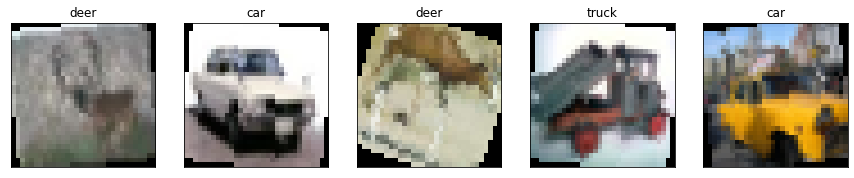

In [8]:
#Displaying a random 7 images for the training set
show_images(train_loader, 5)


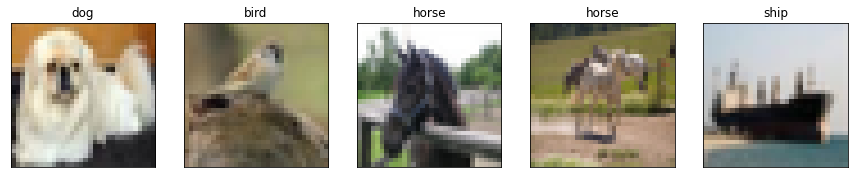

In [10]:
#Displaying a random 7 images for the testing set
show_images(test_loader, 5)


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [11]:
class CIFAR10_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*10*10, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input):
        output = self.dropout(F.relu(self.bn1(self.conv1(input))))
        output = self.dropout(F.relu(self.bn2(self.conv2(output))))
        output = self.dropout(F.relu(self.bn3(self.conv3(output))))
        output = self.pool(output)
        output = output.view(output.shape[0], -1)
        output = self.dropout(F.relu(self.fc1(output)))
        output = self.dropout(F.relu(self.fc2(output)))
        output = F.log_softmax(self.fc3(output), dim=1)

        return output

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [47]:
model = CIFAR10_model()
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.99)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

Plot the training loss (and validation loss/accuracy, if recorded).

In [48]:
# Use the GPU of the machine if available
device = torch.device('cpu')
print('Running on', device)
model.to(device)

Running on cpu


CIFAR10_model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [49]:
# Train the model
epochs = 30

train_losses = []
val_losses = []
val_accuracies =[]

for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        val_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                val_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(accuracy/len(val_loader))

        print('Epoch: {}/{}.. '.format(epoch+1, epochs),
              'Training Loss: {:.3f}.. '.format(running_loss/len(train_loader)),
              'Validation Loss: {:.3f}.. '.format(val_loss/len(val_loader)),
              'Validation Accuracy: {:.3f}'.format(accuracy/len(val_loader)))

Epoch: 1/30..  Training Loss: 1.838..  Validation Loss: 1.518..  Validation Accuracy: 0.447
Epoch: 2/30..  Training Loss: 1.535..  Validation Loss: 1.375..  Validation Accuracy: 0.513
Epoch: 3/30..  Training Loss: 1.430..  Validation Loss: 1.266..  Validation Accuracy: 0.545
Epoch: 4/30..  Training Loss: 1.362..  Validation Loss: 1.193..  Validation Accuracy: 0.568
Epoch: 5/30..  Training Loss: 1.307..  Validation Loss: 1.167..  Validation Accuracy: 0.583
Epoch: 6/30..  Training Loss: 1.253..  Validation Loss: 1.099..  Validation Accuracy: 0.609
Epoch: 7/30..  Training Loss: 1.218..  Validation Loss: 1.058..  Validation Accuracy: 0.620
Epoch: 8/30..  Training Loss: 1.186..  Validation Loss: 1.024..  Validation Accuracy: 0.647
Epoch: 9/30..  Training Loss: 1.160..  Validation Loss: 1.013..  Validation Accuracy: 0.652
Epoch: 10/30..  Training Loss: 1.130..  Validation Loss: 1.002..  Validation Accuracy: 0.649
Epoch: 11/30..  Training Loss: 1.120..  Validation Loss: 0.983..  Validation Ac

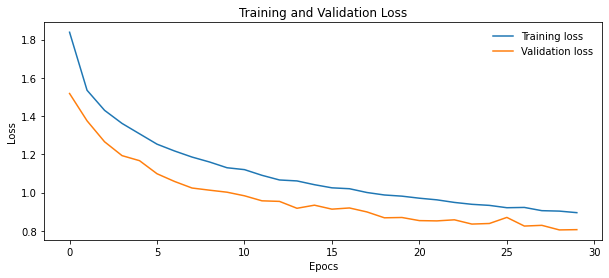

In [50]:
# Plot the training loss of the model
plt.figure(figsize = [10, 4])
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epocs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(frameon=False)
plt.show()

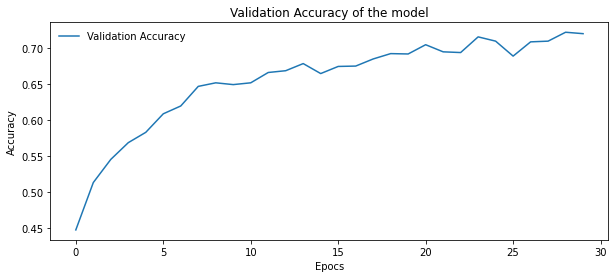

In [51]:
# Plotting the accuracy throughout the Epocs
plt.figure(figsize = [10, 4])
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epocs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy of the model')
plt.legend(frameon=False)
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [52]:
accuracy = 0
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
print('Test Accuracy: {:.1f}%'.format(accuracy/len(test_loader)*100))

Test Accuracy: 72.2%


## Saving your model
Using `torch.save`, save your model for future loading.

In [53]:
CIFAR10_model_checkpoint = {'state_dict': model.state_dict(),
                            'optim_dict':optimizer.state_dict()}

torch.save(CIFAR10_model_checkpoint, 'CIFAR10_30_CPU_Epoch_Slower_TR.pth')

As one can see, we can achieve an accuracy of around 72.2% on the CIFAR Dataset. This was done with a fairly simple model. With more accurate models set up, we could achieve an even higher accuracy rate. With this in mind, I don't think is would be a good idea to purachase the model, rather we should just build it in house. 

Additionally, links to research at the top of this documents show methods to getting up to a 99% accuracy. 